In [314]:
from tqdm.notebook import tqdm
import torch
import pandas as pd
import torch.nn as nn
import transformers
from utils.dataset import MyDataset
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [315]:
from utils.common_functions import get_emotions
emotions = get_emotions().values()
n_labels = len(emotions)
def get_labels():
    labels = list(emotions)
    return labels

## Loading Dataset (D4)

In [316]:
# input_text = input("Enter a text")
df = pd.read_csv('/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/trend-data/trend_dataset_class8_reduced2.csv')
# df2 = pd.read_csv('/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/trend_data/hate_offensive_neither_Tweet_processed.csv')
# df3 = pd.read_csv('/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/trend_data/insult_tweets_2014_to_2021_processed.csv')

In [317]:
# df1.drop('id', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
# df3.drop('Unnamed: 0', axis=1, inplace=True)

In [318]:
df.head(10)

,Unnamed: 0.1,text,obscene,threat,insult,hate,toxic,offensive,neither,approval
0,0,"""\n\nDear Jesus. Really, has Vander Plaats rea...",1.0,0.0,1.0,1.0,1.0,0.0,0,0.0
1,1,"You NDP attack queers, sorry, Cabal of Sanctim...",0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2,4,Unspecified source for Image:Nana.JPG\n\nThank...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
3,5,"""\n(person) (is || is not) (status), where sta...",1.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,6,The National Fat Cunt Prevention Board \n\nMy ...,1.0,0.0,1.0,0.0,1.0,0.0,0,0.0
5,9,"""\n\n Dear Wanker \n\nIt's called a talk page ...",1.0,0.0,0.0,0.0,1.0,0.0,0,0.0
6,10,"hello, does anyone want to play with my pussy?",1.0,0.0,0.0,0.0,1.0,0.0,0,0.0
7,11,"You could try that, but it won't work. You're...",0.0,0.0,0.0,0.0,1.0,0.0,0,0.0
8,12,"""""""Nazi filth"""" is impolite 04:27, 20 Jan 200...",0.0,0.0,1.0,0.0,1.0,0.0,0,0.0
9,15,I hate you Zad68 unblock me you stupid motherf...,1.0,0.0,1.0,0.0,1.0,0.0,0,0.0


In [319]:
from utils.preprocessing import get_clean_dataset
df = get_clean_dataset(df)
df.head()

,Unnamed: 0.1,text,obscene,threat,insult,hate,toxic,offensive,neither,approval
0,0,Dear Jesus Really Vander Plaats really become ...,1.0,0.0,1.0,1.0,1.0,0.0,0,0.0
1,1,attack queers sorry Cabal Sanctimonious Hypocr...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2,4,Unspecified source ImageNanaJPG Thanks uploadi...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
3,5,person status where status abstract concept wi...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,6,National Cunt Prevention Board name Norman fro...,1.0,0.0,1.0,0.0,1.0,0.0,0,0.0


In [320]:
trends = ["approval","toxic","obscene", 'insult', "threat", "hate", "offensive", "neither"]

In [321]:
def get_trend(row):
    # print(row)
    f = False
    t = []

    if row['approval'] == 1:
        f = True
        t.append('approval')

    if row['toxic'] == 1:
        f = True
        t.append('toxic')
    if row['obscene'] == 1:
        f = True
        t.append('obscene')
    
    if row['insult'] == 1:
        f = True
        t.append('insult')

    if row['threat'] == 1:
        f = True
        t.append('threat')
    if row['hate'] == 1:
        f = True
        t.append('hate')

    if row['offensive'] == 1:
        f = True
        t.append('offensive')

    if row['neither'] == 1:
        f = True
        t.append('neither')

    return list(t)

df['trend_type'] = df.apply(lambda x: get_trend(x), axis=1)

In [322]:
df.head(10)

,Unnamed: 0.1,text,obscene,threat,insult,hate,toxic,offensive,neither,approval,trend_type
0,0,Dear Jesus Really Vander Plaats really become ...,1.0,0.0,1.0,1.0,1.0,0.0,0,0.0,"[toxic, obscene, insult, hate]"
1,1,attack queers sorry Cabal Sanctimonious Hypocr...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,[neither]
2,4,Unspecified source ImageNanaJPG Thanks uploadi...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,[neither]
3,5,person status where status abstract concept wi...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,[obscene]
4,6,National Cunt Prevention Board name Norman fro...,1.0,0.0,1.0,0.0,1.0,0.0,0,0.0,"[toxic, obscene, insult]"
5,9,Dear Wanker called talk page reason giving str...,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,"[toxic, obscene]"
6,10,hello does anyone want play with pussy,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,"[toxic, obscene]"
7,11,could that wont work Youre smart enough figure...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,[toxic]
8,12,Nazi filth impolite,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,"[toxic, insult]"
9,15,hate unblock stupid motherfucker,1.0,0.0,1.0,0.0,1.0,0.0,0,0.0,"[toxic, obscene, insult]"


## Applying E-BERT to predict 28 emotions probability of each comment of dataset D4

In [323]:
from utils.dataset import Dataset

def build_dataset(tokenizer_max_len, tokenizer):
    dataset = Dataset(df.text.tolist(), [], tokenizer, tokenizer_max_len)
    return dataset
    # return train_dataset, valid_dataset

def build_dataloader(dataset, batch_size):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    return data_loader
    # return train_data_loader, valid_data_loader

In [324]:
from utils.bert_classifier import get_model_tokenizer, Tokenize, Classification
# Test sentiment prediction
# test_text = "I love you"
model, tokenizer = get_model_tokenizer(pred_type='emotion_pred',
                                        mode_pt_file='best_emotion_bert-base-uncased-22_12_2023-16_41_11.pt', 
                                       model_ckpt='bert-base-uncased', labels=28, is_freez=1, gpu='cuda')

# dict = Tokenize(text=comment, max_length=30, tokenizer=tokenizer)
# scores = Classification(dict=dict, model=model, gpu='cuda:0')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [325]:
from utils.test import test_fn

dataset = build_dataset(tokenizer_max_len=30, tokenizer=tokenizer)
data_loader = build_dataloader(dataset, batch_size=16)
preds = test_fn(data_loader=data_loader, model=model, device='cuda')

  0%|          | 0/1866 [00:00<?, ?it/s]

In [326]:
preds = torch.stack(preds)
preds = preds.cpu().detach().numpy()

In [327]:
# preds

In [328]:
# comment_ids = text_ids.tolist()
comments_texts = df.text.tolist()
trend_types = df.trend_type.tolist()
df1 = df[trends]

## Mapping Emotion Vs Trends to make D'4

In [329]:
map_list = []
labels = get_labels()
for i, t in enumerate(comments_texts):
    data_map = {}
    # data_map['id'] = id
    data_map['text'] = comments_texts[i]
    data_map['trend_type'] = trend_types[i]
    for j, label in enumerate(labels):
        data_map[label] = preds[i][j]
    map_list.append(data_map)

In [330]:
df_trend_emotion = pd.DataFrame(data=map_list)
df_trend_emotion.head(5)

,text,trend_type,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Dear Jesus Really Vander Plaats really become ...,"[toxic, obscene, insult, hate]",0.021382,0.002084,0.028600,0.061120,0.105084,0.019133,0.009545,0.019750,...,0.000395,0.001792,0.091845,0.009531,0.055386,0.001571,0.000571,0.001130,0.006038,0.514809
1,attack queers sorry Cabal Sanctimonious Hypocr...,[neither],0.026765,0.005533,0.001197,0.005646,0.163315,0.007232,0.002180,0.004648,...,0.001115,0.000224,0.023285,0.009330,0.039976,0.005059,0.000442,0.000362,0.004588,0.543943
2,Unspecified source ImageNanaJPG Thanks uploadi...,[neither],0.001641,0.001889,0.007599,0.039692,0.030036,0.007891,0.017040,0.047608,...,0.000406,0.000744,0.020491,0.000658,0.007941,0.000719,0.000231,0.000427,0.001228,0.785755
3,person status where status abstract concept wi...,[obscene],0.001214,0.000498,0.010598,0.008720,0.007651,0.001154,0.001145,0.001642,...,0.000289,0.000185,0.000960,0.000938,0.002196,0.000404,0.000240,0.003253,0.001804,0.943823
4,National Cunt Prevention Board name Norman fro...,"[toxic, obscene, insult]",0.025207,0.001287,0.002734,0.014507,0.056109,0.005868,0.002548,0.002458,...,0.000768,0.000911,0.013396,0.012552,0.020379,0.004411,0.001873,0.003129,0.000952,0.767211


In [331]:
df_trend_emotion.shape

(29853, 30)

In [332]:
df_trend_emotion['trend_type'].value_counts()

[toxic]                                   5682
[neither]                                 5412
[toxic, obscene, insult]                  4844
[offensive]                               4190
[approval]                                2620
[toxic, obscene]                          1915
[hate]                                    1484
[toxic, insult]                           1215
[toxic, obscene, insult, hate]             862
[insult]                                   314
[obscene]                                  311
[toxic, obscene, insult, threat]           187
[obscene, insult]                          172
[toxic, insult, hate]                      142
[toxic, hate]                              134
[toxic, threat]                            115
[toxic, obscene, insult, threat, hate]      86
[toxic, obscene, hate]                      39
[insult, hate]                              32
[obscene, insult, hate]                     21
[toxic, insult, threat]                     20
[threat]     

In [333]:
df_new = pd.concat([df_trend_emotion, df1], axis=1)

In [334]:
df_new.head(5)

,text,trend_type,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,surprise,neutral,approval,toxic,obscene,insult,threat,hate,offensive,neither
0,Dear Jesus Really Vander Plaats really become ...,"[toxic, obscene, insult, hate]",0.021382,0.002084,0.028600,0.061120,0.105084,0.019133,0.009545,0.019750,...,0.006038,0.514809,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0
1,attack queers sorry Cabal Sanctimonious Hypocr...,[neither],0.026765,0.005533,0.001197,0.005646,0.163315,0.007232,0.002180,0.004648,...,0.004588,0.543943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Unspecified source ImageNanaJPG Thanks uploadi...,[neither],0.001641,0.001889,0.007599,0.039692,0.030036,0.007891,0.017040,0.047608,...,0.001228,0.785755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,person status where status abstract concept wi...,[obscene],0.001214,0.000498,0.010598,0.008720,0.007651,0.001154,0.001145,0.001642,...,0.001804,0.943823,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,National Cunt Prevention Board name Norman fro...,"[toxic, obscene, insult]",0.025207,0.001287,0.002734,0.014507,0.056109,0.005868,0.002548,0.002458,...,0.000952,0.767211,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0


## Saving dataset (D'4)

In [335]:
df_new.to_csv('/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/trend-data/emotion_trend_mapping(updated-D4).csv')

## Trend Prediction using XGBoost

In [336]:
X_test = df_new.iloc[:, 2:-8]

In [337]:
X_test

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0.021382,0.002084,0.028600,0.061120,0.105084,0.019133,0.009545,0.019750,0.021715,0.005981,...,0.000395,0.001792,0.091845,0.009531,0.055386,0.001571,0.000571,0.001130,0.006038,0.514809
1,0.026765,0.005533,0.001197,0.005646,0.163315,0.007232,0.002180,0.004648,0.004107,0.001900,...,0.001115,0.000224,0.023285,0.009330,0.039976,0.005059,0.000442,0.000362,0.004588,0.543943
2,0.001641,0.001889,0.007599,0.039692,0.030036,0.007891,0.017040,0.047608,0.006998,0.002776,...,0.000406,0.000744,0.020491,0.000658,0.007941,0.000719,0.000231,0.000427,0.001228,0.785755
3,0.001214,0.000498,0.010598,0.008720,0.007651,0.001154,0.001145,0.001642,0.000391,0.003451,...,0.000289,0.000185,0.000960,0.000938,0.002196,0.000404,0.000240,0.003253,0.001804,0.943823
4,0.025207,0.001287,0.002734,0.014507,0.056109,0.005868,0.002548,0.002458,0.002490,0.019900,...,0.000768,0.000911,0.013396,0.012552,0.020379,0.004411,0.001873,0.003129,0.000952,0.767211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29848,0.002270,0.001965,0.763356,0.106044,0.006816,0.000992,0.001552,0.001343,0.000366,0.006427,...,0.000160,0.000316,0.001476,0.000933,0.004807,0.000495,0.000595,0.001747,0.001491,0.048593
29849,0.004676,0.010108,0.181699,0.265539,0.017552,0.000990,0.003189,0.003471,0.000423,0.014938,...,0.000177,0.000656,0.002204,0.001365,0.011926,0.000681,0.000716,0.002532,0.004007,0.404209
29850,0.004829,0.002262,0.034438,0.078702,0.013305,0.000952,0.001185,0.001176,0.000562,0.019254,...,0.000325,0.000386,0.001880,0.001182,0.006198,0.000465,0.000922,0.003402,0.002265,0.788797
29851,0.005373,0.016828,0.418820,0.171942,0.060257,0.007929,0.003399,0.009235,0.004916,0.003335,...,0.000590,0.000549,0.014492,0.004973,0.007343,0.003664,0.000316,0.001236,0.004622,0.200263


In [338]:
import pickle

# Load the XGBoost model from the .pkl file
with open('/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/Main-Implementation/model_save/trend_pred/grid_xgb.pickle', 'rb') as file:
    xgb_model = pickle.load(file)


In [339]:
y_pred = xgb_model.predict_proba(X_test)

In [340]:
y_pred[0:, 1]

array([0.9779415 , 0.01245597, 0.02254168, ..., 0.9792326 , 0.9255734 ,
       0.9932975 ], dtype=float32)

In [341]:
map_list = []
for i, t in enumerate(comments_texts):
    data_map = {}
    # data_map['id'] = id
    data_map['text'] = comments_texts[i]
    data_map['trend_type'] = trend_types[i]
    for j, label in enumerate(trends):
        data_map[label] = y_pred[i][j]
    map_list.append(data_map)

In [342]:
df_trend1 = pd.DataFrame(data=map_list)
df_trend1.head(5)

,text,trend_type,approval,toxic,obscene,insult,threat,hate,offensive,neither
0,Dear Jesus Really Vander Plaats really become ...,"[toxic, obscene, insult, hate]",0.002541,0.977942,0.979103,0.976566,0.000364,0.983363,0.002233,0.002798
1,attack queers sorry Cabal Sanctimonious Hypocr...,[neither],0.000598,0.012456,0.008105,0.013029,0.000044,0.001873,0.000987,0.988672
2,Unspecified source ImageNanaJPG Thanks uploadi...,[neither],0.000865,0.022542,0.005435,0.012325,0.000061,0.003306,0.001469,0.973479
3,person status where status abstract concept wi...,[obscene],0.000712,0.014361,0.001216,0.001304,0.000032,0.985838,0.000563,0.005498
4,National Cunt Prevention Board name Norman fro...,"[toxic, obscene, insult]",0.000822,0.992821,0.981630,0.979336,0.000070,0.000968,0.001592,0.001144


## Trend Prdiction using T-BERT

In [343]:
from utils.bert_classifier import get_model_tokenizer, Tokenize, Classification
# Test sentiment prediction
# test_text = "I love you"
model, tokenizer = get_model_tokenizer(pred_type='trend_pred',
                                        mode_pt_file='best_trend_bert-base-uncased-26_12_2023-22_01_29.pt', 
                                       model_ckpt='bert-base-uncased', labels=8, is_freez=0, gpu='cuda')

# dict = Tokenize(text=comment, max_length=30, tokenizer=tokenizer)
# scores = Classification(dict=dict, model=model, gpu='cuda:0')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [344]:
from utils.test import test_fn

dataset = build_dataset(tokenizer_max_len=30, tokenizer=tokenizer)
data_loader = build_dataloader(dataset, batch_size=16)
preds = test_fn(data_loader=data_loader, model=model, device='cuda')

  0%|          | 0/1866 [00:00<?, ?it/s]

In [345]:
preds = torch.stack(preds)
preds = preds.cpu().detach().numpy()

In [346]:
map_list = []
for i, t in enumerate(comments_texts):
    data_map = {}
    # data_map['id'] = id
    # data_map['text'] = comments_texts[i]
    # data_map['trend_type'] = trend_types[i]
    for j, label in enumerate(trends):
        data_map[label] = preds[i][j]
    map_list.append(data_map)

In [347]:
df_trend2 = pd.DataFrame(data=map_list)
df_trend2.head(5)

,approval,toxic,obscene,insult,threat,hate,offensive,neither
0,0.000692,0.000656,0.000399,0.000397,0.000180,0.000276,0.000250,0.997151
1,0.001578,0.550631,0.009437,0.033973,0.002744,0.387114,0.004113,0.010408
2,0.000766,0.322746,0.229024,0.192044,0.001141,0.144739,0.108816,0.000724
3,0.000119,0.853796,0.010188,0.133872,0.000257,0.001439,0.000098,0.000231
4,0.000612,0.000481,0.000345,0.000368,0.000171,0.000356,0.000283,0.997384


In [348]:
df_new = pd.concat([df_trend1, df_trend2, df1], axis=1)

In [349]:
df_new.head()

,text,trend_type,approval,toxic,obscene,insult,threat,hate,offensive,neither,...,offensive,neither,approval,toxic,obscene,insult,threat,hate,offensive,neither
0,Dear Jesus Really Vander Plaats really become ...,"[toxic, obscene, insult, hate]",0.002541,0.977942,0.979103,0.976566,0.000364,0.983363,0.002233,0.002798,...,0.000250,0.997151,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0
1,attack queers sorry Cabal Sanctimonious Hypocr...,[neither],0.000598,0.012456,0.008105,0.013029,0.000044,0.001873,0.000987,0.988672,...,0.004113,0.010408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Unspecified source ImageNanaJPG Thanks uploadi...,[neither],0.000865,0.022542,0.005435,0.012325,0.000061,0.003306,0.001469,0.973479,...,0.108816,0.000724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,person status where status abstract concept wi...,[obscene],0.000712,0.014361,0.001216,0.001304,0.000032,0.985838,0.000563,0.005498,...,0.000098,0.000231,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,National Cunt Prevention Board name Norman fro...,"[toxic, obscene, insult]",0.000822,0.992821,0.981630,0.979336,0.000070,0.000968,0.001592,0.001144,...,0.000283,0.997384,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0


In [350]:
# importing the required libraries 
import matplotlib.pyplot as plt 
import numpy as np 

start = 0
end = df_new.shape[0]

idx1 = 3 # XGBoot output
idx2 = idx1+8 # T-BERT output
idx3 = idx2+8 # Original output

# x1 = [i for i in range(len(list(df_new.iloc[start:end, idx1])))]
# x2 = [i for i in range(len(list(df_new.iloc[start:end, idx2])))]
# x3 = [i for i in range(len(list(df_new.iloc[start:end, idx3])))]

data1 = np.array(list(df_new.iloc[start:end, idx1]))
data2 = np.array(list(df_new.iloc[start:end, idx2]))
data3 = np.array(list(df_new.iloc[start:end, idx3]))

# print(data1)
# print(data3)

# plt.plot(x1, data1)  # Plot the chart
# plt.plot(x2, data2)  # Plot the chart
# plt.plot(x3, data3)  # Plot the chart

# plt.show()  # display 

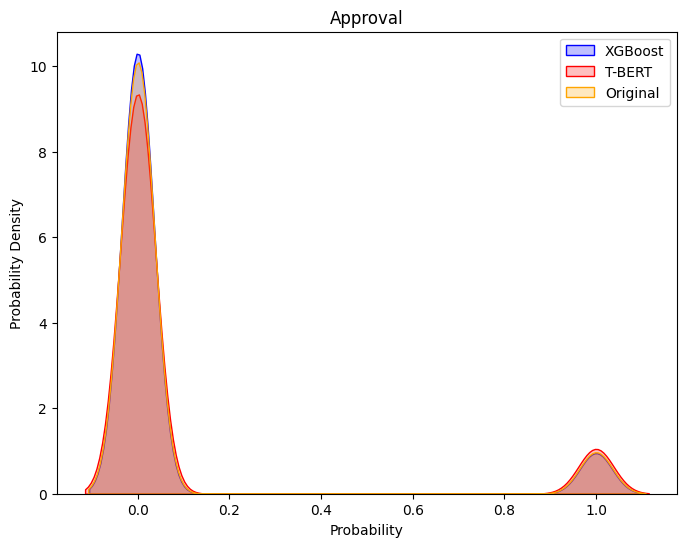

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data (replace this with your data)
# np.random.seed(0)
# data1 = np.random.normal(loc=0, scale=1, size=1000)
# data2 = np.random.normal(loc=0.5, scale=1.2, size=1000)

# Histograms
# plt.figure(figsize=(8, 6))
# plt.hist(data1 - data2, bins=30, alpha=0.7, label='Difference Histogram')
# plt.xlabel('Difference')
# plt.ylabel('Frequency')
# plt.title('Deviation: Difference Histogram')
# plt.legend()
# plt.show()

# Overlayed Histograms
# plt.figure(figsize=(8, 6))
# sns.histplot(data1, kde=True, color='blue', label='Data 1', alpha=0.5)
# sns.histplot(data2, kde=True, color='orange', label='Data 2', alpha=0.5)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Deviation: Overlayed Histograms')
# plt.legend()
# plt.show()

# Kernel Density Estimation (KDE) Plots

idx1 = 2
idx2 = idx1+8
idx3 = idx2+8
# Creating subplots
data1 = np.array(list(df_new.iloc[start:end, idx1]))
data2 = np.array(list(df_new.iloc[start:end, idx2]))
data3 = np.array(list(df_new.iloc[start:end, idx3]))

data1 = np.where(data1 > 0.3, 1, 0)
data2 = np.where(data2 > 0.3, 1, 0)

plt.figure(figsize=(8, 6))  # 2 rows, 4 columns
sns.kdeplot(data1, color='blue', label='XGBoost', shade=True)
sns.kdeplot(data2, color='red', label='T-BERT', shade=True)
sns.kdeplot(data3, color='orange', label='Original', shade=True)

plt.xlabel('Probability')
plt.ylabel('Probability Density')

plt.legend()
plt.title('Approval')
# Show the plots
plt.show()

# Box Plots or Violin Plots
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=[data1, data2])
# plt.xticks(ticks=[0, 1], labels=['Data 1', 'Data 2'])
# plt.xlabel('Dataset')
# plt.ylabel('Value')
# plt.title('Deviation: Box Plot')
# plt.show()

# Cumulative Distribution Plots (ECDF)
# plt.figure(figsize=(8, 6))
# sns.ecdfplot(data=data1, label='Data 1')
# sns.ecdfplot(data=data2, label='Data 2')
# plt.xlabel('Value')
# plt.ylabel('ECDF')
# plt.title('Deviation: ECDF Plots')
# plt.legend()
# plt.show()

# QQ Plot
# plt.figure(figsize=(6, 6))
# sns.qqplot(data1, data2)
# plt.xlabel('Quantiles of Data 1')
# plt.ylabel('Quantiles of Data 2')
# plt.title('Deviation: QQ Plot')
# plt.show()

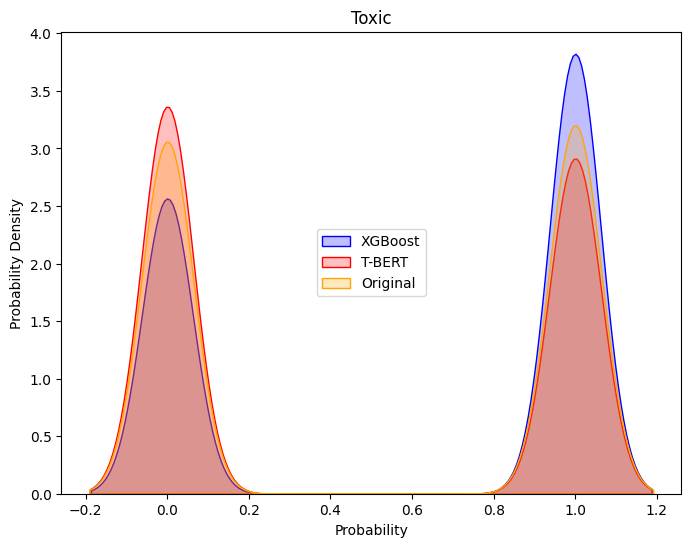

In [352]:
idx1 = 3
idx2 = idx1+8
idx3 = idx2+8
# Creating subplots
data1 = np.array(list(df_new.iloc[start:end, idx1]))
data2 = np.array(list(df_new.iloc[start:end, idx2]))
data3 = np.array(list(df_new.iloc[start:end, idx3]))

data1 = np.where(data1 > 0.3, 1, 0)
data2 = np.where(data2 > 0.3, 1, 0)

plt.figure(figsize=(8, 6))  # 2 rows, 4 columns
sns.kdeplot(data1, color='blue', label='XGBoost', shade=True)
sns.kdeplot(data2, color='red', label='T-BERT', shade=True)
sns.kdeplot(data3, color='orange', label='Original', shade=True)

plt.xlabel('Probability')
plt.ylabel('Probability Density')

plt.legend(loc='center')
plt.title('Toxic')
# Show the plots
plt.show()

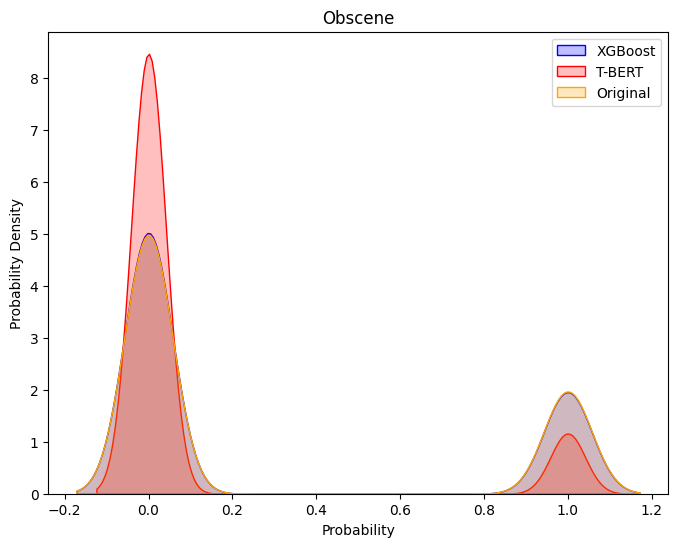

In [353]:
idx1 = 4
idx2 = idx1+8
idx3 = idx2+8
# Creating subplots
data1 = np.array(list(df_new.iloc[start:end, idx1]))
data2 = np.array(list(df_new.iloc[start:end, idx2]))
data3 = np.array(list(df_new.iloc[start:end, idx3]))

data1 = np.where(data1 > 0.3, 1, 0)
data2 = np.where(data2 > 0.3, 1, 0)

plt.figure(figsize=(8, 6))  # 2 rows, 4 columns
sns.kdeplot(data1, color='blue', label='XGBoost', shade=True)
sns.kdeplot(data2, color='red', label='T-BERT', shade=True)
sns.kdeplot(data3, color='orange', label='Original', shade=True)

plt.xlabel('Probability')
plt.ylabel('Probability Density')

plt.legend()
plt.title('Obscene')
# Show the plots
plt.show()

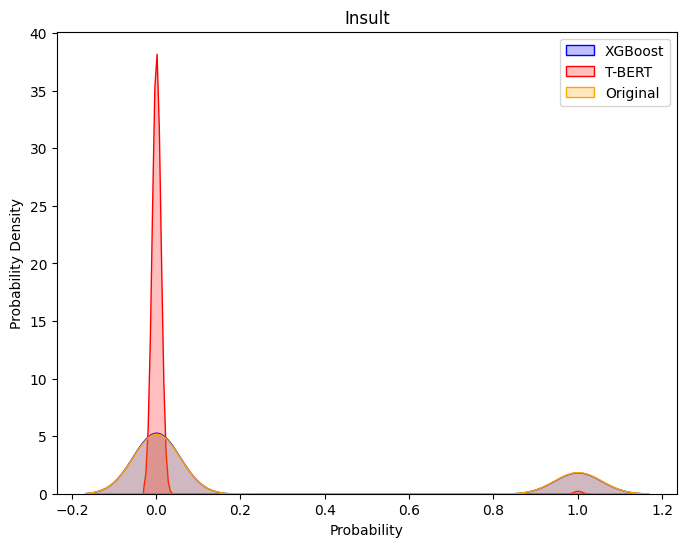

In [354]:
idx1 = 5
idx2 = idx1+8
idx3 = idx2+8
# Creating subplots
data1 = np.array(list(df_new.iloc[start:end, idx1]))
data2 = np.array(list(df_new.iloc[start:end, idx2]))
data3 = np.array(list(df_new.iloc[start:end, idx3]))

data1 = np.where(data1 > 0.3, 1, 0)
data2 = np.where(data2 > 0.3, 1, 0)

plt.figure(figsize=(8, 6))  # 2 rows, 4 columns
sns.kdeplot(data1, color='blue', label='XGBoost', shade=True)
sns.kdeplot(data2, color='red', label='T-BERT', shade=True)
sns.kdeplot(data3, color='orange', label='Original', shade=True)

plt.xlabel('Probability')
plt.ylabel('Probability Density')

plt.legend()
plt.title('Insult')
# Show the plots
plt.show()

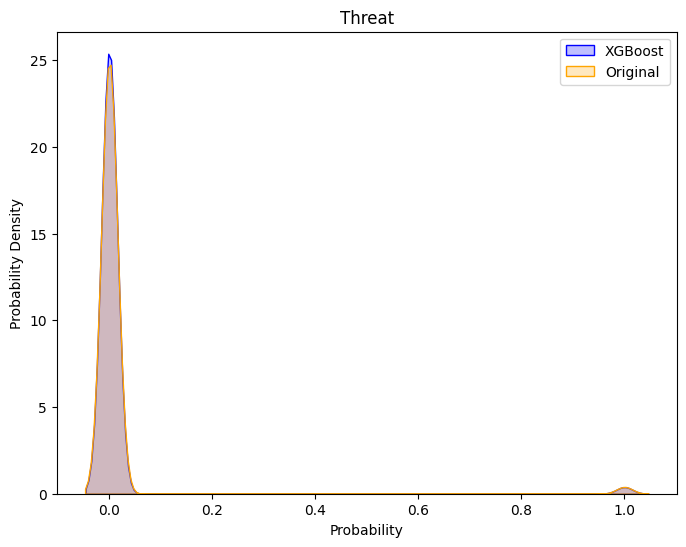

In [355]:
idx1 = 6
idx2 = idx1+8
idx3 = idx2+8
# Creating subplots
data1 = np.array(list(df_new.iloc[start:end, idx1]))
data2 = np.array(list(df_new.iloc[start:end, idx2]))
data3 = np.array(list(df_new.iloc[start:end, idx3]))

data1 = np.where(data1 > 0.3, 1, 0)
data2 = np.where(data2 > 0.3, 1, 0)

plt.figure(figsize=(8, 6))  # 2 rows, 4 columns
sns.kdeplot(data1, color='blue', label='XGBoost', shade=True)
sns.kdeplot(data2, color='red', label='T-BERT', shade=True)
sns.kdeplot(data3, color='orange', label='Original', shade=True)

plt.xlabel('Probability')
plt.ylabel('Probability Density')

plt.legend()
plt.title('Threat')
# Show the plots
plt.show()

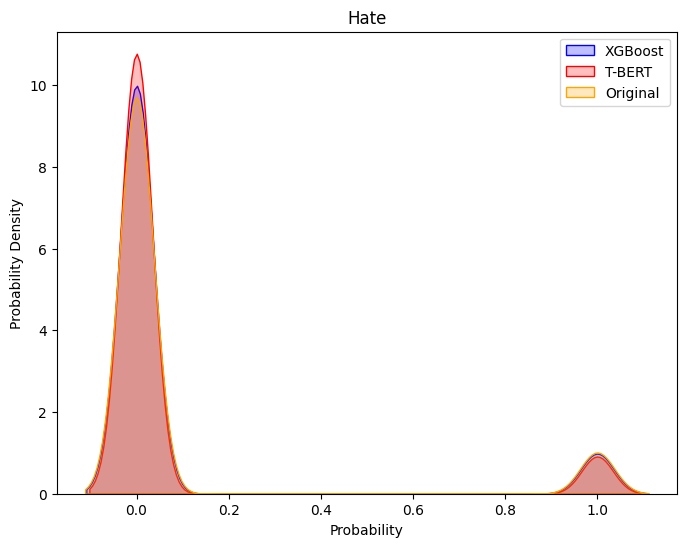

In [356]:
idx1 = 7
idx2 = idx1+8
idx3 = idx2+8
# Creating subplots
data1 = np.array(list(df_new.iloc[start:end, idx1]))
data2 = np.array(list(df_new.iloc[start:end, idx2]))
data3 = np.array(list(df_new.iloc[start:end, idx3]))

data1 = np.where(data1 > 0.3, 1, 0)
data2 = np.where(data2 > 0.3, 1, 0)

plt.figure(figsize=(8, 6))  # 2 rows, 4 columns
sns.kdeplot(data1, color='blue', label='XGBoost', shade=True)
sns.kdeplot(data2, color='red', label='T-BERT', shade=True)
sns.kdeplot(data3, color='orange', label='Original', shade=True)

plt.xlabel('Probability')
plt.ylabel('Probability Density')

plt.legend()
plt.title('Hate')
# Show the plots
plt.show()

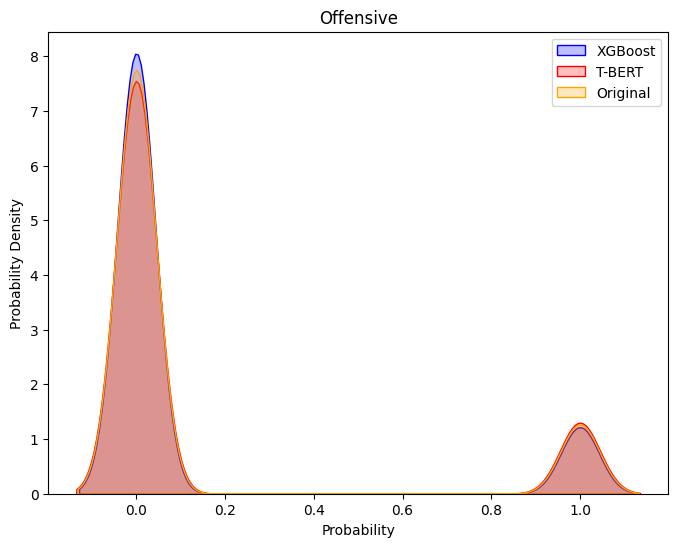

In [357]:
idx1 = 8
idx2 = idx1+8
idx3 = idx2+8
# Creating subplots
data1 = np.array(list(df_new.iloc[start:end, idx1]))
data2 = np.array(list(df_new.iloc[start:end, idx2]))
data3 = np.array(list(df_new.iloc[start:end, idx3]))

data1 = np.where(data1 > 0.3, 1, 0)
data2 = np.where(data2 > 0.3, 1, 0)

plt.figure(figsize=(8, 6))  # 2 rows, 4 columns
sns.kdeplot(data1, color='blue', label='XGBoost', shade=True)
sns.kdeplot(data2, color='red', label='T-BERT', shade=True)
sns.kdeplot(data3, color='orange', label='Original', shade=True)

plt.xlabel('Probability')
plt.ylabel('Probability Density')

plt.legend()
plt.title('Offensive')
# Show the plots
plt.show()

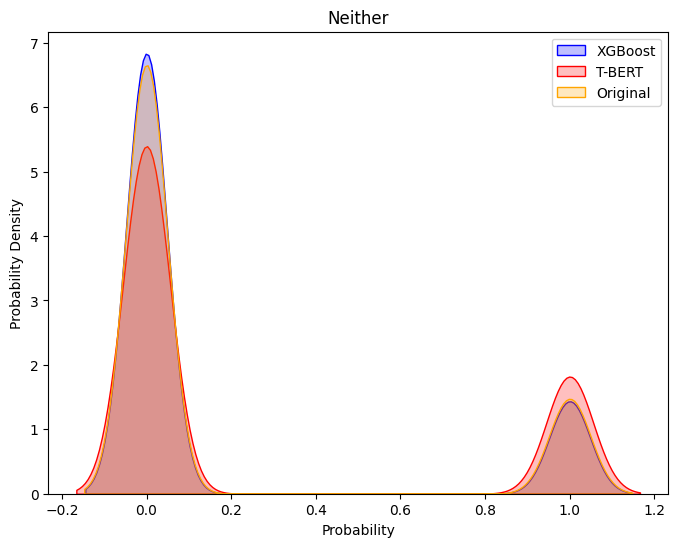

In [358]:
idx1 = 9
idx2 = idx1+8
idx3 = idx2+8
# Creating subplots
data1 = np.array(list(df_new.iloc[start:end, idx1]))
data2 = np.array(list(df_new.iloc[start:end, idx2]))
data3 = np.array(list(df_new.iloc[start:end, idx3]))

data1 = np.where(data1 > 0.3, 1, 0)
data2 = np.where(data2 > 0.3, 1, 0)

plt.figure(figsize=(8, 6))  # 2 rows, 4 columns
sns.kdeplot(data1, color='blue', label='XGBoost', shade=True)
sns.kdeplot(data2, color='red', label='T-BERT', shade=True)
sns.kdeplot(data3, color='orange', label='Original', shade=True)

plt.xlabel('Probability')
plt.ylabel('Probability Density')

plt.legend()
plt.title('Neither')
# Show the plots
plt.show()

In [360]:
data1 = np.array(list(df_new.iloc[start:end, idx1])) # XGBoost
data2 = np.array(list(df_new.iloc[start:end, idx2])) # T-BERT

In [363]:
data1 = np.where(data1 > 0.3, 1, 0)
data1.shape

(29853,)

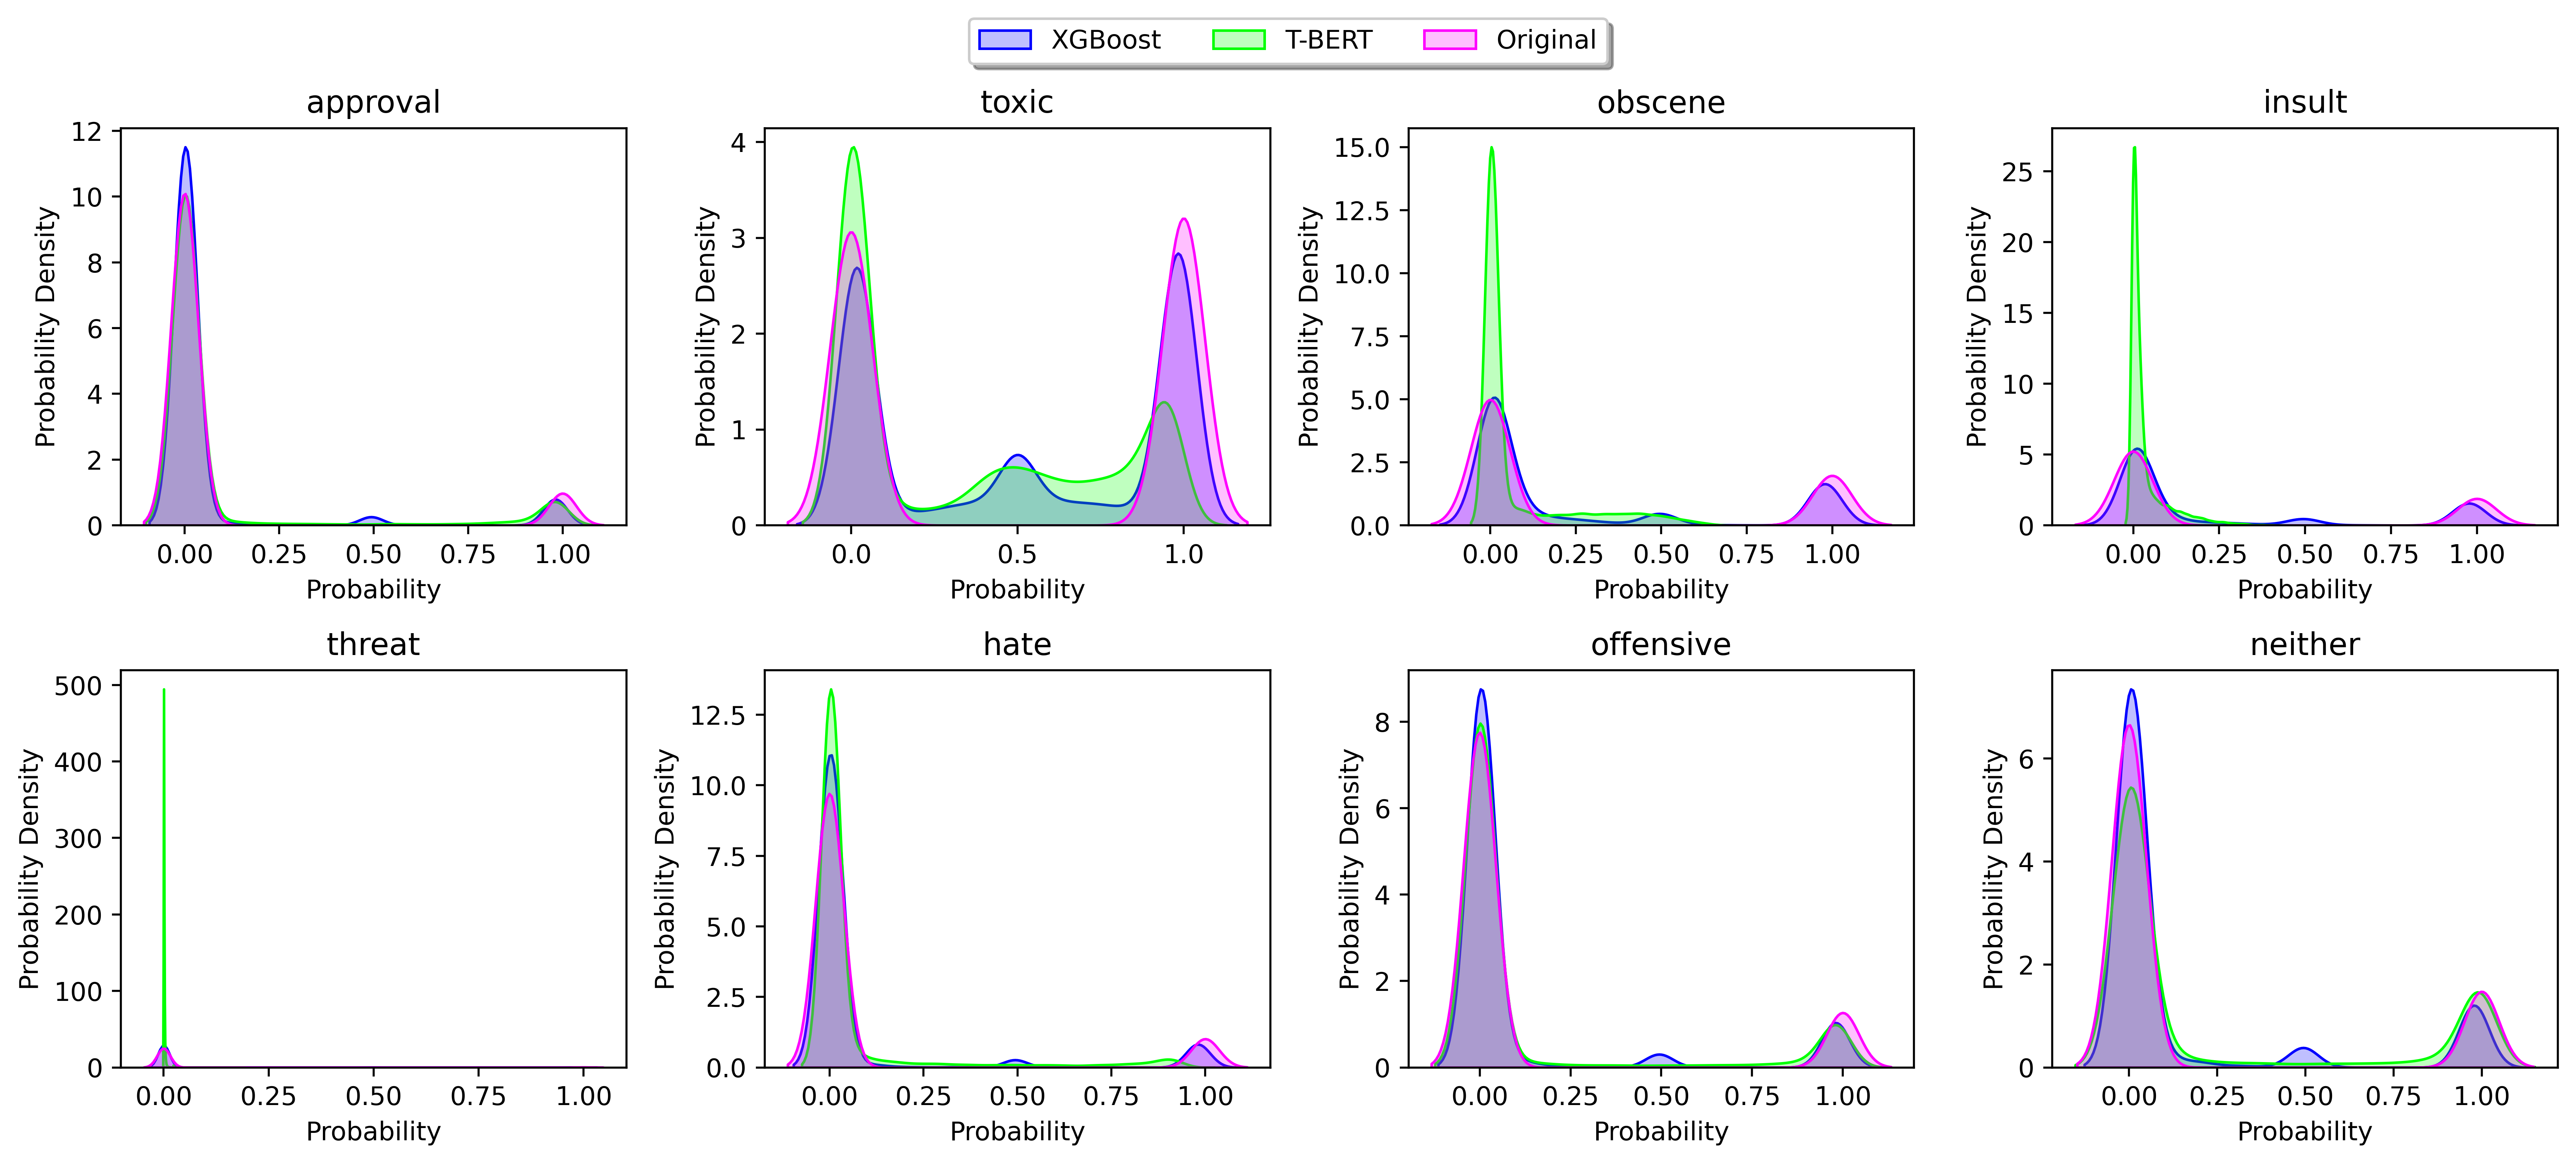

In [364]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 6), dpi=500)

start = 0
end = df_new.shape[0]

# Assuming df_new is your DataFrame and start/end are defined
for i, ax in enumerate(axs.flatten()):
    idx1 = i + 2
    idx2 = idx1 + 8
    idx3 = idx2 + 8
    
    data1 = np.array(list(df_new.iloc[start:end, idx1])) # XGBoost
    data2 = np.array(list(df_new.iloc[start:end, idx2])) # T-BERT
    data3 = np.array(list(df_new.iloc[start:end, idx3])) # Original

    # data1 = np.where(data1 > 0.3, 1, 0)
    # data2 = np.where(data2 > 0.3, 1, 0)

    # Use Seaborn's kdeplot within each subplot
    sns.kdeplot(data=data1, color='blue', label='XGBoost', shade=True, ax=ax)
    sns.kdeplot(data=data2, color='lime', label='T-BERT', shade=True, ax=ax)
    sns.kdeplot(data=data3, color='magenta', label='Original', shade=True, ax=ax)

    ax.set_xlabel('Probability')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'{trends[i]}')
    # ax.legend(loc='upper center')

# Adjust layout to prevent overlap
plt.tight_layout()
fig.legend(labels=['XGBoost','T-BERT','Original'], loc='upper center', bbox_to_anchor=(0.5, 1.05), shadow=True, ncol=3)

# Show the plots
plt.show()